Используйте готовый ноутбук с занятия:
1. Обучите автокодировщик на 10 выбранных вами красивых цифрах 5 и отредактируйте с помощью него все остальные цифры 5
2. Напишите 3 автокодировщика для подавления шума с собственными архитектурами. Сравните их между собой и с исходным шумоподавляющим атокодировщиком. Сравнивайте по квадрату разности исходной картинки с востановленной из шума
3. Обучите автокодировщик на базе Fashion Mnist, проверьте, как он преобразует картинки одежды, на которых не обучался

# Импорт библиотек

In [ ]:
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist, fashion_mnist 
from tensorflow.keras.callbacks import LambdaCallback

import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing import image
import numpy as np  
import pandas as pd 
from PIL import Image 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 

import os 
from google.colab import drive 
import time, random
import seaborn as sns
sns.set_style('darkgrid') 

# Вспомогательные функции

## Функция создания автокодировщика

In [ ]:
def baseAutoencoder(shape=(112,80,1)): 
    img_input = Input((shape)) 

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x) 

    z = MaxPooling2D()(x) 
    

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) 
    x = BatchNormalization()(x) 
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
     
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 

    x = BatchNormalization()(x) 

    x = Conv2D(shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error')

    return model

## Функция вывода изображений

In [ ]:
def plotImages(xTrain, pred, shape=(112, 80)): 
  n = 5
  plt.figure(figsize=(14, 7))
  for i in range(n):
      index = np.random.randint(0, pred.shape[0]) 
 
      ax = plt.subplot(2, n, i + 1) 
      plt.imshow(xTrain[index].reshape(shape)) 
      plt.gray() 
      ax.get_xaxis().set_visible(False)  
      ax.get_yaxis().set_visible(False) 
 
      ax = plt.subplot(2, n, i + 1 + n) 
      plt.imshow(pred[index].reshape(shape))   
      plt.gray() 
      ax.get_xaxis().set_visible(False) 
      ax.get_yaxis().set_visible(False) 
  plt.show()

## Функция получения средней квадратичной ошибки

In [ ]:
def getMSE(x1, x2): 
  x1 = x1.flatten() 
  x2 = x2.flatten() 
  delta = x1 - x2 
  return sum(delta ** 2) / len(delta) 

In [ ]:
x1 = np.array([1, 1, 1]) 
x2 = np.array([1, 1, 1]) 
print(getMSE(x1,x2))

0.0


## Функция для загрузки изображений

In [ ]:
def load_images(images_dir, img_height, img_width): 
  list_images = []
  for img in os.listdir(images_dir):
    list_images.append(image.img_to_array(image.load_img(os.path.join(images_dir, img), target_size=(img_height, img_width), color_mode='grayscale')))
  return np.array(list_images) 

# Подготовка данных

In [ ]:
(xTrainMnist, yTrainMnist), (xTestMnist, yTestMnist) = mnist.load_data() 
xTrainMnist = xTrainMnist.astype('float32')/255 
xTrainMnist = xTrainMnist.reshape(-1, 28, 28, 1) 
xTestMnist = xTestMnist.astype('float32')/255 
xTestMnist = xTestMnist.reshape(-1, 28, 28, 1) 

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
fivesTrain = list()
fivesTest = list()
for ii in range(len(xTrainMnist)):
  if yTrainMnist[ii] == 5:
    fivesTrain.append(xTrainMnist[ii])

for ii in range(len(xTestMnist)):
  if yTestMnist[ii] == 5:
    fivesTest.append(xTestMnist[ii])
print(len(fivesTest))
print(len(fivesTrain))

fivesTrain = np.array(fivesTrain)
fivesTest = np.array(fivesTest)

892
5421


In [ ]:
print(fivesTest.shape)
print(xTrainMnist.shape)

print(type(xTrainMnist))
print(type(fivesTest))

(892, 28, 28, 1)
(60000, 28, 28, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
modelAutoMnist = baseAutoencoder((28,28,1))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
modelAutoMnist.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_54 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_55 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 32)          0   

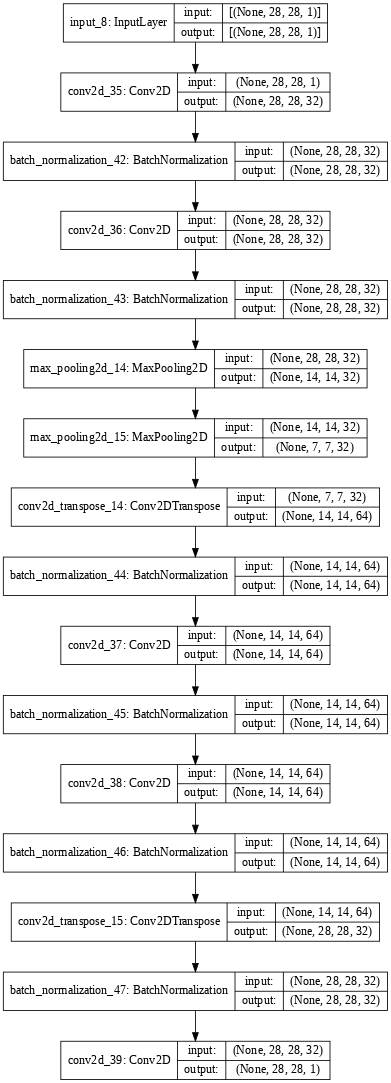

In [ ]:
utils.plot_model(modelAutoMnist, dpi=60, show_shapes=True)

In [ ]:
history = modelAutoMnist.fit(fivesTrain, fivesTrain, epochs=50, batch_size=256, validation_data = (fivesTest, fivesTest))

Epoch 1/50
22/22 [==============================] - 37s 2s/step - loss: 0.0659 - val_loss: 0.1234
Epoch 2/50
22/22 [==============================] - 37s 2s/step - loss: 0.0562 - val_loss: 0.1113
Epoch 3/50
22/22 [==============================] - 37s 2s/step - loss: 0.0484 - val_loss: 0.1010
Epoch 4/50
22/22 [==============================] - 37s 2s/step - loss: 0.0421 - val_loss: 0.0916
Epoch 5/50
22/22 [==============================] - 37s 2s/step - loss: 0.0370 - val_loss: 0.0806
Epoch 6/50
22/22 [==============================] - 37s 2s/step - loss: 0.0328 - val_loss: 0.0674
Epoch 7/50
22/22 [==============================] - 37s 2s/step - loss: 0.0293 - val_loss: 0.0542
Epoch 8/50
22/22 [==============================] - 37s 2s/step - loss: 0.0264 - val_loss: 0.0445
Epoch 9/50
22/22 [==============================] - 37s 2s/step - loss: 0.0240 - val_loss: 0.0379
Epoch 10/50
22/22 [==============================] - 37s 2s/step - loss: 0.0219 - val_loss: 0.0343
Epoch 11/50
22/22 [

На удаление

In [ ]:
predMnistTest = modelAutoMnist.predict(fivesTest)
predMnistTest = predMnistTest * 255
predMnistTest = predMnistTest.astype('uint8')

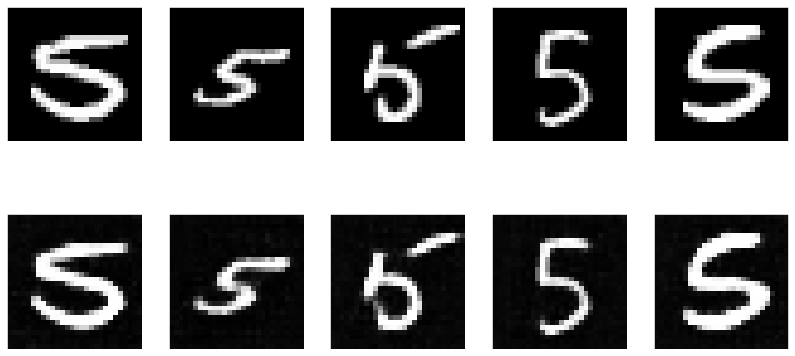

In [ ]:
plotImages(fivesTest, predMnistTest, shape=(28,28))

In [ ]:
err1 = [getMSE(fivesTrain[i], predMnistTrain[i] / 255) for i in range(len(predMnistTrain))]
err2 = [getMSE(fivesTest[i], predMnistTest[i] / 255) for i in range(len(predMnistTest))]
print("Средняя ошибка на обучающем наборе MNIST:", sum(err1) / xTrainMnist.shape[0])
print("Средняя ошибка на тестовом наборе MNIST:", sum(err2) /xTestMnist.shape[0])

Средняя ошибка на обучающем наборе MNIST: 0.0004242261028427946
Средняя ошибка на тестовом наборе MNIST: 0.00042198186464301114
